# #5. Automatization

0. [Motivation](#Motivation)
1. [Networking](#Networking)
    1. [socket](#socket)
    2. [TCP](#TCP)
    3. [UDP](#UDP)
    4. [HTTP](#HTTP)
    5. [web-servers](#web-servers)
2. [Databases](#Databases)
    1. [DB API](#DB-API)
    2. [Libraries](#Libraries)
    3. [ping-reconnect](#ping-reconnect)
    4. [Timeouts and retries](#Timeouts-and-retries)
    5. [Slow quries](#Slow-quries)
    6. [SQL-injections](#SQL-injections)
    7. [Concurrent access](#Concurrent-access)
    8. [Connection pool](#Connection-pool)
    9. [Caching](#Caching)
3. [Daemons](#Daemons)
    1. [Daemonization](#Daemonization)
    2. [Config](#Config)
    3. [Logging](#Logging)
4. [Deployment](#Deployment)
    1. [Python-only](#Python-only)
    2. [Linux distribution](#Linux-distribution)

## Motivation

__Goal__

Получить знания об особенносятх сетевого взаимодействия, изучить нюансы общения со сторонними сервисами и создания собственных

__Homework__

HTTP Server

## Networking

#### socket

In [ ]:
import socket

class Connection(object):
    '''\
    Represents connection to the Tarantool server.

    This class is responsible for connection and network exchange with the server.
    Also this class provides low-level interface to data manipulation (insert/delete/update/select).
    '''

    def __init__(self, host, port,
                 socket_timeout=SOCKET_TIMEOUT,
                 reconnect_max_attempts=RECONNECT_MAX_ATTEMPTS,
                 reconnect_delay=RECONNECT_DELAY,
                 connect_now=True,
                 schema=None):
        '''\
        Initialize a connection to the server.

        :param str host: Server hostname or IP-address
        :param int port: Server port
        :param bool connect_now: if True (default) than __init__() actually creates network connection.
                             if False than you have to call connect() manualy.
        :param schema: Data schema (see Developer guide and :class:`~tarantool.schema.Schema`)
        :type schema: :class:`~tarantool.schema.Schema` or dict
        '''
        self.host = host
        self.port = port
        self.socket_timeout = socket_timeout
        self.reconnect_delay = reconnect_delay
        self.reconnect_max_attempts = reconnect_max_attempts
        if isinstance(schema, Schema):
            self.schema = schema
        else:
            self.schema = Schema(schema)
        self._socket = None
        if connect_now:
            self.connect()


    def close(self):
        '''\
        Close connection to the server
        '''
        self._socket.close()
        self._socket = None


    def connect(self):
        '''\
        Create connection to the host and port specified in __init__().
        Usually there is no need to call this method directly,
        since it is called when you create an `Connection` instance.

        :raise: `NetworkError`
        '''

        try:
            # If old socket already exists - close it and re-create
            if self._socket:
                self._socket.close()
            self._socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self._socket.setsockopt(socket.SOL_TCP, socket.TCP_NODELAY, 1)
            #self._socket.setsockopt(socket.SOL_TCP, socket.SO_REUSEADDR, 1)
            #self._socket.setsockopt(socket.SOL_TCP, socket.SO_REUSEPORT, 1)
            self._socket.connect((self.host, self.port))
            # It is important to set socket timeout *after* connection.
            # Otherwise the timeout exception will rised, even if the server does not listen
            self._socket.settimeout(self.socket_timeout)
        except socket.error as e:
            raise NetworkError(e)


    def _read_response(self):
        '''
        Read response from the transport (socket)

        :return: tuple of the form (header, body)
        :rtype: tuple of two byte arrays
        '''

        buf = ''
        l = 12

        while True:
            r = self._socket.recv(l - len(buf))
            if not r:
                err = socket.error("Connection reset by peer")
                err.errno = errno.ECONNRESET
                raise err
            buf += r
            if len(buf) < l:
                continue

            l = 12 + struct_L.unpack(buf[4:8])[0] # struct.unpack("<Q", buf[4:8])[0]

            if len(buf) < l:
                continue

            return buf[0:12], buf[12:]

        
    def _send_request_wo_reconnect(self, request, space_name = None, field_defs = None, default_type = None):
        '''\
        :rtype: `Response` instance

        :raise: NetworkError
        '''
        assert isinstance(request, Request)

        # Repeat request in a loop if the server returns completion_status == 1 (try again)
        for attempt in xrange(self.RETRY_MAX_ATTEMPTS):    # pylint: disable=W0612
            try:
                self._socket.sendall(bytes(request))
                header, body = self._read_response()
                response = Response(self, header, body, space_name, field_defs, default_type)
            except socket.error as e:
                raise NetworkError(e)

            if response.completion_status != 1:
                return response
            warn(response.return_message, RetryWarning)

        # Raise an error if the maximum number of attempts have been made
        raise DatabaseError(response.return_code, response.return_message)

Socket is not file object but `makefile` fixes it
* It's easy to write programs that mysteriously "freeze up" or don't operate quite like you would expect

In [ ]:
class HTTPResponse:

    # strict: If true, raise BadStatusLine if the status line can't be
    # parsed as a valid HTTP/1.0 or 1.1 status line.  By default it is
    # false because it prevents clients from talking to HTTP/0.9
    # servers.  Note that a response with a sufficiently corrupted
    # status line will look like an HTTP/0.9 response.

    # See RFC 2616 sec 19.6 and RFC 1945 sec 6 for details.

    def __init__(self, sock, debuglevel=0, strict=0, method=None, buffering=False):
        if buffering:
            # The caller won't be using any sock.recv() calls, so buffering
            # is fine and recommended for performance.
            self.fp = sock.makefile('rb')
        else:
            # The buffer size is specified as zero, because the headers of
            # the response are read with readline().  If the reads were
            # buffered the readline() calls could consume some of the
            # response, which make be read via a recv() on the underlying
            # socket.
            self.fp = sock.makefile('rb', 0)
        self.debuglevel = debuglevel
        self.strict = strict
        self._method = method

        self.msg = None

        # from the Status-Line of the response
        self.version = _UNKNOWN # HTTP-Version
        self.status = _UNKNOWN  # Status-Code
        self.reason = _UNKNOWN  # Reason-Phrase

        self.chunked = _UNKNOWN         # is "chunked" being used?
        self.chunk_left = _UNKNOWN      # bytes left to read in current chunk
        self.length = _UNKNOWN          # number of bytes left in response
        self.will_close = _UNKNOWN      # conn will close at end of response

    def _read_status(self):
        # Initialize with Simple-Response defaults
        line = self.fp.readline(_MAXLINE + 1)
        if len(line) > _MAXLINE:
            raise LineTooLong("header line")
        if self.debuglevel > 0:
            print "reply:", repr(line)
        if not line:
            # Presumably, the server closed the connection before
            # sending a valid response.
            raise BadStatusLine(line)
        try:
            [version, status, reason] = line.split(None, 2)
        except ValueError:
            try:
                [version, status] = line.split(None, 1)
                reason = ""
            except ValueError:
                # empty version will cause next test to fail and status
                # will be treated as 0.9 response.
                version = ""
        if not version.startswith('HTTP/'):
            if self.strict:
                self.close()
                raise BadStatusLine(line)
            else:
                # assume it's a Simple-Response from an 0.9 server
                self.fp = LineAndFileWrapper(line, self.fp)
                return "HTTP/0.9", 200, ""

        # The status code is a three-digit number
        try:
            status = int(status)
            if status < 100 or status > 999:
                raise BadStatusLine(line)
        except ValueError:
            raise BadStatusLine(line)
        return version, status, reason

Be aware that reading/writing to a socket may involve partial data transfer
* send() returns actual bytes sent
    * you want to use s.sendall(data) - blocks until all is sent
* recv() length is only a maximum limit
    * will return empty string when connections has been closed
* for TCP, the data stream is continuous - no concept of records, etc.

In [ ]:
>>> len(data)
1000000
>>> s.send(data)
37722
>>>
>>> data = s.recv(10000)
>>> len(data)
6420

In [ ]:
# Client
...
s.send(data)
s.send(moredata)
...
# Server
...
data = s.recv(maxsize) # This recv() may return data
                       # from both of the sends
                       # combined or less data than
                       # even the first send

#### TCP

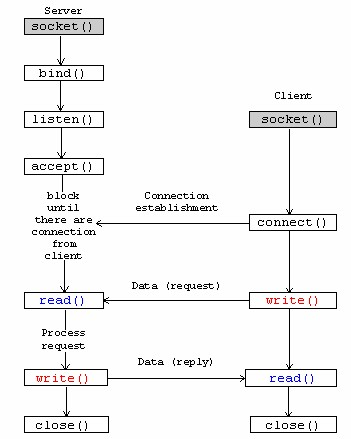

In [ ]:
from socket import *
s = socket(AF_INET, SOCK_STREAM)
s.bind(("", 9000))
s.listen(5)
while True:
    c, a = s.accept()
    print "Received connection from", a
    c.sendall("Hello %s\n" % a[0])
    c.close()

In [121]:
def _eintr_retry(func, *args):
    """restart a system call interrupted by EINTR"""
    while True:
        try:
            return func(*args)
        except (OSError, select.error) as e:
            if e.args[0] != errno.EINTR:
                raise

                
class BaseServer:
    timeout = None
    def __init__(self, server_address, RequestHandlerClass):
        """Constructor.  May be extended, do not override."""
        self.server_address = server_address
        self.RequestHandlerClass = RequestHandlerClass
        self.__is_shut_down = threading.Event()
        self.__shutdown_request = False

    def serve_forever(self, poll_interval=0.5):
        """Handle one request at a time until shutdown.
        Polls for shutdown every poll_interval seconds. Ignores
        self.timeout. If you need to do periodic tasks, do them in
        another thread.
        """
        self.__is_shut_down.clear()
        try:
            while not self.__shutdown_request:
                # XXX: Consider using another file descriptor or
                # connecting to the socket to wake this up instead of
                # polling. Polling reduces our responsiveness to a
                # shutdown request and wastes cpu at all other times.
#                 r, w, e = select.select([self], [], [], poll_interval)
                r, w, e = _eintr_retry(select.select, [self], [], [],
                                       poll_interval)
                if self in r:
                    self._handle_request_noblock()
        finally:
            self.__shutdown_request = False
            self.__is_shut_down.set()

    def shutdown(self):
        """Stops the serve_forever loop.
        Blocks until the loop has finished. This must be called while
        serve_forever() is running in another thread, or it will
        deadlock.
        """
        self.__shutdown_request = True
        self.__is_shut_down.wait()

    def _handle_request_noblock(self):
        """Handle one request, without blocking.
        I assume that select.select has returned that the socket is
        readable before this function was called, so there should be
        no risk of blocking in get_request().
        """
        try:
            request, client_address = self.get_request()
        except socket.error:
            return
        if self.verify_request(request, client_address):
            try:
                self.process_request(request, client_address)
            except:
                self.handle_error(request, client_address)
                self.shutdown_request(request)
        else:
            self.shutdown_request(request)

    def process_request(self, request, client_address):
        """Call finish_request.
        Overridden by ForkingMixIn and ThreadingMixIn.
        """
        self.finish_request(request, client_address)
        self.shutdown_request(request)

    def finish_request(self, request, client_address):
        """Finish one request by instantiating RequestHandlerClass."""
        self.RequestHandlerClass(request, client_address, self)

In [ ]:
class TCPServer(BaseServer):
    address_family = socket.AF_INET
    socket_type = socket.SOCK_STREAM
    request_queue_size = 5
    allow_reuse_address = False

    def __init__(self, server_address, RequestHandlerClass, bind_and_activate=True):
        """Constructor.  May be extended, do not override."""
        BaseServer.__init__(self, server_address, RequestHandlerClass)
        self.socket = socket.socket(self.address_family,
                                    self.socket_type)
        if bind_and_activate:
            try:
                self.server_bind()
                self.server_activate()
            except:
                self.server_close()
                raise

    def server_bind(self):
        """Called by constructor to bind the socket.
        May be overridden.
        """
        if self.allow_reuse_address:
            self.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        self.socket.bind(self.server_address)
        self.server_address = self.socket.getsockname()

    def server_activate(self):
        """Called by constructor to activate the server.
        May be overridden.
        """
        self.socket.listen(self.request_queue_size)

    def server_close(self):
        """Called to clean-up the server.
        May be overridden.
        """
        self.socket.close()

    def fileno(self):
        """Return socket file number.
        Interface required by select().
        """
        return self.socket.fileno()

    def get_request(self):
        """Get the request and client address from the socket.
        May be overridden.
        """
        return self.socket.accept()

    def shutdown_request(self, request):
        """Called to shutdown and close an individual request."""
        try:
            #explicitly shutdown.  socket.close() merely releases
            #the socket and waits for GC to perform the actual close.
            request.shutdown(socket.SHUT_WR)
        except socket.error:
            pass #some platforms may raise ENOTCONN here
        self.close_request(request)

    def close_request(self, request):
        """Called to clean up an individual request."""
        request.close()


#### UDP

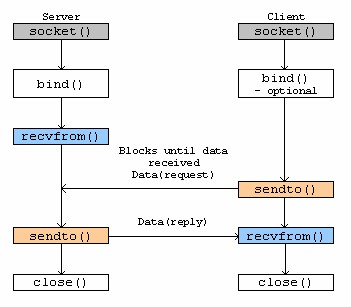

In [ ]:
# Simple server
from socket import *
s = socket(AF_INET, SOCK_DGRAM)
s.bind(("", 10000))
while True:
    data, addr = s.recvfrom(maxsize)
    resp = "Get off my lawn!"
    s.sendto(resp,addr)

In [ ]:
# Simple client
from socket import *
s = socket(AF_INET, SOCK_DGRAM)
msg = "Hello World"
s.sendto(msg,("server.com", 10000))
data, addr = s.recvfrom(maxsize)

In [ ]:
class UDPServer(TCPServer):

    """UDP server class."""

    allow_reuse_address = False

    socket_type = socket.SOCK_DGRAM

    max_packet_size = 8192

    def get_request(self):
        data, client_addr = self.socket.recvfrom(self.max_packet_size)
        return (data, self.socket), client_addr

    def server_activate(self):
        # No need to call listen() for UDP.
        pass

    def shutdown_request(self, request):
        # No need to shutdown anything.
        self.close_request(request)

    def close_request(self, request):
        # No need to close anything.
        pass

#### HTTP

In [125]:
class HTTPFS:
    def __init__(self, config):
        self.httfs_base_url = config["HTTPFS"]

    def download(self, f, path, timeout=60):
        url = urlparse.urljoin(self.httfs_base_url, f["path"].lstrip("/") + "?op=OPEN")
        logging.info("Requesting %s" % url)
        request = urllib2.urlopen(url, timeout=timeout)
        headers = request.info()
        size = -1
        if "content-length" in headers:
            size = int(headers["content-length"])
        chunk_size = 1024 * 1024
        read = 0
        with open(path, "w") as fp:
            while True:
                chunk = request.read(chunk_size)
                if not chunk:
                    break
                fp.write(chunk)
                read += len(chunk)
        if size > 0 and read < size:
            raise ValueError("Retrieval incomplete: got only %s out of %s bytes" % (read, size))

    def query(self, url, timeout=10):
        max_retries = 3
        err = Exception("Max retries exceeded")
        logging.info("Requesting %s" % url)
        for _ in xrange(max_retries):
            try:
                return urllib2.urlopen(url, timeout=timeout).read()
            except urllib2.URLError as err:
                if err.errno in (errno.ETIMEDOUT, socket.EAI_NONAME):
                    continue
                raise
        raise err

In [ ]:
import urllib2

fields = {
 'txtUsername' : 'dave',
 'txtPassword' : '12345',
 'submit_login' : 'Log In'
}
opener = urllib2.build_opener(
    urllib2.HTTPCookieProcessor()
)
request = urllib2.Request(
    "http://somedomain.com/login.asp",
     urllib.urlencode(fields)
)
# Login
u = opener.open(request)
resp = u.read()
# Get a page, but use cookies returned by initial login
u = opener.open("http://somedomain.com/private.asp")
resp = u.read()

In [124]:
class Storage(object):
    def __init__(self, host_port, conn_timeout=None, read_timeout=None, api_access=None):
        self.host_port = host_port
        self.session = requests.Session()
        self.session.mount("http://", requests.adapters.HTTPAdapter(max_retries=3))
        if api_access:
            self.session.headers.update({"Authorization": "ApiKey %s:%s" % api_access})
        self.timeout = (conn_timeout or CONN_TIMEOUT, read_timeout or READ_TIMEOUT)

    def send(self, request, **kwargs):
        response = self.session.send(request.prepare(), timeout=self.timeout, **kwargs)
        response.raise_for_status()
        return response

    def get(self, url):
        request = requests.Request("GET", url)
        response = self.send(request, stream=True)
        return response.raw

    def head(self, url):
        request = requests.Request("HEAD", url)
        try:
            response = self.send(request)
        except requests.HTTPError as e:
            if e.response.status_code == 404:
                return None
            else:
                raise e
        return response.headers

#### web-servers

* Forking
* Threading
* Event-based

In [ ]:
import socket
import threading

bind_ip = '0.0.0.0'
bind_port = 9999

server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server.bind((bind_ip, bind_port))
server.listen(5)  # max backlog of connections

print('Listening on {}:{}'.format(bind_ip, bind_port))


def handle_client_connection(client_socket):
    request = client_socket.recv(1024)
    print('Received {}'.format(request))
    client_socket.send('ACK!')
    client_socket.close()

while True:
    client_sock, address = server.accept()
    print('Accepted connection from {}:{}'.format(address[0], address[1]))
    client_handler = threading.Thread(
        target=handle_client_connection,
        args=(client_sock,)  # without comma you'd get a... TypeError: handle_client_connection() argument after * must be a sequence, not _socketobject
    )
    client_handler.start()

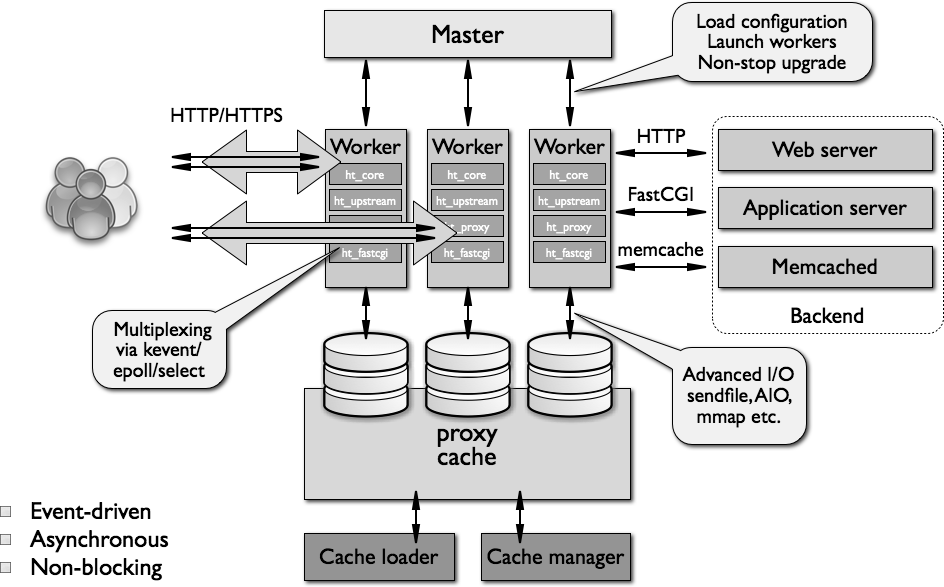

### References

* https://amarchenko.dev/translate/2023-10-02-network/
* http://www.apress.com/us/book/9781430230038
* http://www.dabeaz.com/python/PythonNetBinder.pdf
* http://www.tenouk.com/Module39a.html
* https://docs.python.org/2.7/howto/sockets.html
* https://hpbn.co/
* http://berb.github.io/diploma-thesis/original/042_serverarch.html
* https://www.ulduzsoft.com/2014/01/select-poll-epoll-practical-difference-for-system-architects/
* http://www.aosabook.org/en/nginx.html
* https://www.nginx.com/blog/inside-nginx-how-we-designed-for-performance-scale/
* https://www.youtube.com/watch?v=aE0yawwB6h4
* http://www.kegel.com/c10k.html
* https://www.slideshare.net/joshzhu/nginx-internals

### Summary

* sockets are almost file-like, but it's get tricky fast
* TCP is reliable stream-oriented protocol
* UDP is unrealiable packet-oriented protocol. Faster than TCP though
* Always use timeouts and retries
* requests is handy but devil in the details

## Databases

#### DB API

Defines a standard interface for Python database access modules. It’s documented in PEP 249. Nearly all Python database modules conform to this interface
* MySQL
* PostgreSQL
* SQL Server
* Oracle

#### Libraries

In [47]:
import MySQLdb

def dictfetchall(cursor):
    "Return all rows from a cursor as a dict"
    columns = [col[0] for col in cursor.description]
    return [
        dict(zip(columns, row))
        for row in cursor.fetchall()
    ]


db = MySQLdb.connect(host="localhost",user="root", db="imdb", charset="utf8")
cursor = db.cursor() # represent a database cursor, which is used to manage the context of a fetch operation. 
cursor.execute("SELECT VERSION()")
data = cursor.fetchone()
print "Database version : %s " % data
cursor.execute("SELECT * FROM Reviewer")
print dictfetchall(cursor)
cursor.close()
db.close()

Database version : 5.6.20 
[{'rID': 201L, 'name': u'Sarah Martinez'}, {'rID': 202L, 'name': u'Daniel Lewis'}, {'rID': 203L, 'name': u'Brittany Harris'}, {'rID': 204L, 'name': u'Mike Anderson'}, {'rID': 205L, 'name': u'Chris Jackson'}, {'rID': 206L, 'name': u'Elizabeth Thomas'}, {'rID': 207L, 'name': u'James Cameron'}, {'rID': 208L, 'name': u'Ashley White'}]


In [27]:
import peewee

database = peewee.MySQLDatabase("imdb", host="localhost",user="root", charset="utf8")
class BaseModel(peewee.Model):
    class Meta:
        database = database

class Movie(BaseModel):
    mid = peewee.IntegerField(db_column="mID")
    title = peewee.TextField()
    year = peewee.IntegerField()
    director = peewee.TextField()

class Rating(BaseModel):
    mid = peewee.IntegerField(db_column="mID")
    rid = peewee.IntegerField(db_column="rID")
    stars = peewee.IntegerField()
    date = peewee.DateField(db_column="ratingDate")
    
    class Meta:
        primary_key = peewee.CompositeKey('mid', 'rid')

class Reviewer(BaseModel):
    rid = peewee.IntegerField(db_column="rID")
    name = peewee.TextField()

q = Rating.select() \
    .join(Reviewer, on=(Reviewer.rid == Rating.rid)) \
    .join(Movie, on=(Movie.mid == Rating.mid)) \
    .where(Rating.stars >= 4)

print q.sql()
for r  in q:
    print r.mid

('SELECT `t1`.`mID`, `t1`.`rID`, `t1`.`stars`, `t1`.`ratingDate` FROM `rating` AS t1 INNER JOIN `reviewer` AS t2 ON (`t2`.`rID` = `t1`.`rID`) INNER JOIN `movie` AS t3 ON (`t3`.`mID` = `t1`.`mID`) WHERE (`t1`.`stars` >= %s)', [4])
101
106
108
108
106
107


In [34]:
import datetime
from pony import orm

db = orm.Database()
db.bind(provider='mysql', user='root', host='localhost', db='test')

class Cheese(db.Entity):
    type = orm.Required(str)
    purchases = orm.Set(lambda: Purchase)

class Customer(db.Entity):
    name = orm.Required(str)
    purchases = orm.Set(lambda: Purchase)

class Purchase(db.Entity):
    date = orm.Required(datetime.date)
    customer = orm.Required(Customer)
    cheeses = orm.Set(Cheese)

db.generate_mapping(create_tables=True)

camembert = Cheese(type='Camembert')
leicester = Cheese(type='Red Leicester')
cat = Customer(name='Cat')
doug = Customer(name='Douglas')
d = datetime.date(1971, 12, 18)
day = datetime.timedelta(1)
Purchase(date=(d - 1 * day), customer=doug, cheeses={camembert, leicester})
Purchase(date=d, customer=cat, cheeses={camembert})
orm.commit()

yesterday = d - 2 * day 
for cheese in (
        orm.select(p.cheeses for p in Purchase if p.date > yesterday)
    ):
    print(cheese.type)
print

for cheese, purchase_count in (
        orm.left_join((c, orm.count(p))
        for c in Cheese
        for p in c.purchases)
    ):
    print cheese.type, purchase_count

Camembert
Red Leicester
Camembert
Red Leicester
Camembert
Red Leicester
Camembert
Red Leicester

Camembert 2
Red Leicester 1
Camembert 2
Red Leicester 1
Camembert 2
Red Leicester 1
Camembert 2
Red Leicester 1


#### ping-reconnect

In [70]:
from contextlib import closing

class Database(object):
    conn = None

    def __init__(self, config):
        self.host = config.get('host')
        self.user = config.get('user')
        self.password = config.get('password')
        self.database = config.get('database')

    def connect(self):
        self.conn = MySQLdb.connect(host=self.host, user=self.user, db=self.database, charset='utf8')
        self.conn.autocommit(True)  # for InnoDB

    def query(self, sql):
        try:
            self.conn.ping()
        except:
            self.connect()
        with closing(self.conn.cursor()) as cursor:
            cursor.execute(sql)
            return self.dictfetchall(cursor)

    @staticmethod
    def dictfetchall(cursor):
        "Returns all rows from a cursor as a dict"
        desc = cursor.description
        return [
            dict(zip([col[0] for col in desc], row))
            for row in cursor.fetchall()
        ]

db = Database({"host": "localhost", "user": "root", "database": "imdb"})
like = "S"
db.query("SELECT * FROM Reviewer Where name LIKE '%s%%'" % like)

[{'name': u'Sarah Martinez', 'rID': 201L}]

#### SQL-injections

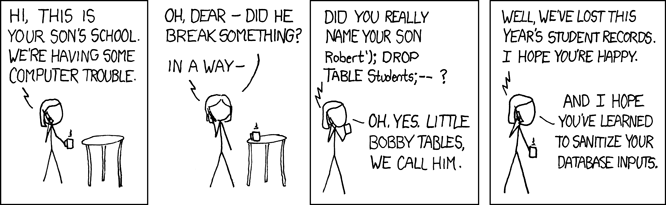

In [84]:
from contextlib import closing

class Database(object):
    conn = None

    def __init__(self, config):
        self.host = config.get('host')
        self.user = config.get('user')
        self.password = config.get('password')
        self.database = config.get('database')

    def connect(self):
        self.conn = MySQLdb.connect(host=self.host, user=self.user, db=self.database, charset='utf8')
        self.conn.autocommit(True)  # for InnoDB

    def query(self, sql, params=()):
        try:
            self.conn.ping()
        except:
            self.connect()
        with closing(self.conn.cursor()) as cursor:
            cursor.execute(sql, params)
            return self.dictfetchall(cursor)

    @staticmethod
    def dictfetchall(cursor):
        "Returns all rows from a cursor as a dict"
        desc = cursor.description
        return [
            dict(zip([col[0] for col in desc], row))
            for row in cursor.fetchall()
        ]


db = Database({"host": "localhost", "user": "root", "database": "imdb"})
like = "S%"
db.query("SELECT * FROM Reviewer Where name LIKE %s", (like,))

[{'name': u'Sarah Martinez', 'rID': 201L}]

#### Timeouts and retries

In [60]:
from contextlib import closing

class Database(object):
    conn = None

    def __init__(self, config):
        self.host = config.get('host')
        self.user = config.get('user')
        self.password = config.get('password')
        self.database = config.get('database')

    def connect(self):
        self.conn = MySQLdb.connect(
            host=self.host,
            user=self.user,
            db=self.database,
            connect_timeout=5,
            charset='utf8'
        )
        self.conn.autocommit(True)  # for InnoDB

    def query(self, sql, params=()):
        try:
            self.conn.ping()
        except:
            self.connect()
        with closing(self.conn.cursor()) as cursor:
            cursor.execute(sql, params)
            return self.dictfetchall(cursor)

    @staticmethod
    def dictfetchall(cursor):
        "Returns all rows from a cursor as a dict"
        desc = cursor.description
        return [
            dict(zip([col[0] for col in desc], row))
            for row in cursor.fetchall()
        ]

In [59]:
class ClientTarantool(object):
    def __init__(self, host, port):
        self.host = host
        self.port = port
        self._conns = []
        self._conns.append(self.get_conn())

    def get_conn(self):
        if not self._conns:
            while True:
                try:
                    return tarantool.Connection(host=self.host, port=self.port,
                                                reconnect_delay=0.01, socket_timeout=5)
                except Exception, e:
                    msg = "Cannot connect to Clients tarantool: %s" % e
                    print msg  # will show up at uwsgi log
                    logging.error(msg)
                    time.sleep(1)
        else:
            return self._conns.pop()

In [61]:
def _send_request(self, request, space_name = None, field_defs = None, default_type = None):
    '''\
    Send the request to the server through the socket.
    Return an instance of `Response` class.

    :param request: object representing a request
    :type request: `Request` instance

    :rtype: `Response` instance
    '''
    assert isinstance(request, Request)

    connected = True
    attempt = 1
    while True:
        try:
            if not connected:
                time.sleep(self.reconnect_delay)
                self.connect()
                connected = True
                warn("Successfully reconnected", NetworkWarning)
            response = self._send_request_wo_reconnect(request, space_name, field_defs, default_type)
            break
        except NetworkError as e:
            if attempt > self.reconnect_max_attempts:
                raise
            warn("%s : Reconnect to %s:%s attempt %d of %d" % (e.message, self.host, self.port,
                 attempt, self.reconnect_max_attempts), NetworkWarning)
            attempt += 1
            connected = False

    return response

In [85]:
class TarantoolMemcache(object):

    def __init__(self, host_port, max_retries=float('inf'), silent=False):
        import memcache
        memcache.SERVER_MAX_KEY_LENGTH = 1000
        self._client = memcache.Client([host_port])
        self._srv = self._client.servers[0]
        self.max_retries = max_retries
        self.silent = silent

    def _reconnect_wrapper(self, func):
        def wrapper(*args, **kwargs):
            while self.max_retries:
                ret = func(*args, **kwargs)

                if not self._srv._check_dead():
                    return ret

                if not self.silent:
                    logging.warning("Tarantool %s:%s is dead. Reconnect in 1 sec" % self._srv.address)
                time.sleep(1)
                self._client.forget_dead_hosts()
                # there is a typo in python-memcached-1.43-6.el6.noarch so `forget_dead_hosts` wont work
                self._srv.deaduntil = 0
                self.max_retries -= 1
            else:
                raise TarantoolException("Failed to execute request")
        return wrapper

    def __getattr__(self, attr):
        a = getattr(self._client, attr)
        if attr in ("get", "get_multi", "set", "set_multi", "delete", "delete_multi", "add"):
            return self._reconnect_wrapper(a)
        return a

    def __del__(self, *args, **kwargs):
        try:
            self._client.disconnect_all()
        except:
            pass

#### Slow quries

In [68]:
from contextlib import closing
import threading

class Database(object):
    conn = None

    def __init__(self, config):
        self.host = config.get('host')
        self.user = config.get('user')
        self.password = config.get('password')
        self.database = config.get('database')
        self.query_timeout = config.get('timeout', 2)

    def get_connection(self):
        return MySQLdb.connect(
            host=self.host,
            user=self.user,
            db=self.database,
            connect_timeout=5,
            charset='utf8'
        )
        
    def connect(self):
        self.conn = self.get_connection()
        self.conn.autocommit(True)  # for InnoDB
        with closing(self.conn.cursor()) as cursor:
            cursor.execute("SELECT CONNECTION_ID()")
            self.conn.id = cursor.fetchone()[0]
        print "Successfully connected with id %s" % self.conn.id

    def _harakiri(self, conn_id):
        # could also use thread.interrupt_main() or os._exit(1)
        conn = self.get_connection()
        print "Killing %s" % conn_id
        with closing(conn.cursor()) as cursor:
            cursor.execute("KILL CONNECTION %s", (conn_id,))
        conn.close()
        
    def query(self, sql, params=()):
        try:
            self.conn.ping()
        except:
            self.connect()

        kill_query_timer = threading.Timer(self.query_timeout, self._harakiri, args=(self.conn.id,))
        kill_query_timer.start()
        try:
            with closing(self.conn.cursor()) as cursor:
                cursor.execute(sql, params)
                return self.dictfetchall(cursor)
        except Exception, e:
            raise e
        finally:
            kill_query_timer.cancel()

    @staticmethod
    def dictfetchall(cursor):
        "Returns all rows from a cursor as a dict"
        desc = cursor.description
        return [
            dict(zip([col[0] for col in desc], row))
            for row in cursor.fetchall()
        ]

db = Database({"host": "localhost", "user": "root", "database": "imdb"})
db.query("SELECT SLEEP(5)")

Successfully connected with id 54
Killing 54


OperationalError: (2013, 'Lost connection to MySQL server during query')

#### Concurrent access

In [86]:
DB_LOCK = threading.Lock()

def send_heartbeat(host):
    update_query = """
        REPLACE INTO `servers`
        SET `host` = %s, `heartbeat` = NOW()
        """
    try:
        with DB_LOCK:
            lib.getdb('db').execute(update_query, host)
    except Exception, e:
        logging.warning("Cannot send heartbeat: %s", repr(e))

In [114]:
import threading
import time
import MySQLdb


class DBThread(threading.Thread):
    def __init__(self, conn, cur, name):
        threading.Thread.__init__(self)
        self.conn = conn
        self.cur = cur
        self.name = name

    def run(self): 
        insql = "INSERT INTO cheese(type) VALUES (%s)"
        delsql = "DELETE FROM cheese WHERE type=%s"
        self.cur.execute(insql, (self.name,))
        self.conn.commit()
        self.cur.execute(delsql, (self.name,))
        self.conn.commit()
        self.cur.close()
        self.conn.close()

threads = []
names = ["cheese1", "cheese2", "cheese3", "cheese4", "cheese5"]

for name in names:
    conn = MySQLdb.connect(host='localhost',user='root',db='test')
    cur = conn.cursor()
    t = DBThread(conn, cur, name)
    threads.append(t)

for th in threads:
    th.start()

for t in threads:
    t.join()

#### Connection pool

In [115]:
def _get_connection_from_pool(key):
    """
        First get from the queue with no wait
    """
    q = _d_connection_queue.get(key)
    connection = None
    try:
        connection = q.get_nowait()
    except Empty:
        print "Connections exhausted"
    if not connection:
        if _get_connected_count(key) < _max_size:
            print 'create extra connection less than max size'
            connection = _create_new_connection_from_key(key)
        else:
            try:
                connection = q.get(timeout=_max_wait_time)
            except Empty:
                print 'waiting connection timeout'
    if connection:
        _update_connected_count(key, 1)
    return connection


def _release_connection(key, connection):
    if connection:
        q = _d_connection_queue[key]
        if _get_connected_count(key) > _max_size:
            connection.close()
        else:
            q.put_nowait(connection)
    _update_connected_count(key, -1)

#### Caching

"There are 2 hard problems in computer science: cache invalidation, naming things, and off-by-1 errors."

In [116]:
class Calendar(object):
    __calendar_cache = {'holidays': set(), 'unholidays': set(), 'timestamp': datetime.datetime.now() - datetime.timedelta(days=2)}
    def __init__(self):
        if datetime.datetime.now() - self.__calendar_cache['timestamp'] > datetime.timedelta(days=1):
            sql = "SELECT * FROM holidays_calendar"
            days = db.query(sql)
            for day in days:
                if day['is_holiday']:
                    self.__calendar_cache['holidays'].add(day['date'])
                else:
                    self.__calendar_cache['unholidays'].add(day['date'])
            self.__calendar_cache['timestamp'] = datetime.datetime.now()

    def check_holiday(self, d):
        if d not in self.__calendar_cache['unholidays']:
            if d.weekday() in (5,6) or d in self.__calendar_cache['holidays']:
                return True
        return False

    def check_unholiday(self, d):
        if d not in self.__calendar_cache['holidays']:
            if d.weekday() not in (5,6) or d in self.__calendar_cache['unholidays']:
                return True
        return False

### References

* https://www.python.org/dev/peps/pep-0249/
* http://docs.peewee-orm.com/en/latest/index.html
* http://mysql-python.sourceforge.net/MySQLdb.html
* https://docs.ponyorm.com/database.html
* https://en.wikipedia.org/wiki/SQL_injection

### Summary

* know your database
* know your database connector
* beware of idle connections
* timeout everything
* don't use one connection from many threads without lock
* use pooling to improve performance but don't leak connections
* use caching to reduce load but don't forget to invalidate

## Daemons

#### Daemonization

In [128]:
import os
import sys

UMASK = 0
WORKDIR = "/"
MAXFD = 1024
if (hasattr(os, "devnull")):
    REDIRECT_TO = os.devnull
else:
    REDIRECT_TO = "/dev/null"

def create_daemon():
    try:
        # 1. makes the shell think that the command is done
        # 2. guaranteed that the child is not a process group leader for setsid
        pid = os.fork()
    except OSError, e:
        raise Exception, "%s [%d]" % (e.strerror, e.errno)

    if (pid == 0):
        # 1. becomes a session leader of a new session
        # 2. becomes the process group leader of a new process group
        # 3. has no controlling terminal
        os.setsid()
        try:
            # 1. makes second child orphaned - init process responsible for cleanup
            # 2. no longer a session leader - prevents from acquiring a controlling terminal
            pid = os.fork()
        except OSError, e:
            raise Exception, "%s [%d]" % (e.strerror, e.errno)

        if (pid == 0):
            os.chdir(WORKDIR)
            os.umask(UMASK)
        else:
            os._exit(0)
    else:
        os._exit(0)

    import resource
    maxfd = resource.getrlimit(resource.RLIMIT_NOFILE)[1]
    if (maxfd == resource.RLIM_INFINITY):
        maxfd = MAXFD
  
    for fd in range(0, maxfd):
        try:
            os.close(fd)
        except OSError:
            pass

    os.open(REDIRECT_TO, os.O_RDWR)
    os.dup2(0, 1)           # standard output (1)
    os.dup2(0, 2)           # standard error (2)
    return 0

Session (SID) → Process Group (PGID) → Process (PID)

1. `Parent`    = PID: 28084, PGID: 28084, SID: 28046
2. `Fork#1`    = PID: 28085, PGID: 28084, SID: 28046
3. `Decouple#1`= PID: 28085, PGID: 28085, SID: 28085
4. `Fork#2`    = PID: 28086, PGID: 28085, SID: 28085

init-script

In [ ]:
#!/bin/bash
. /etc/rc.d/init.d/functions

pname="otusd"
exe="/usr/local/sbin/otusd.py"
pidfile="/var/run/${pname}.pid"
lockfile="/var/lock/${pname}"

[ -x $exe ] || exit 0

RETVAL=0

start() {
    echo -n "Starting $pname : "
    if [ -s ${pidfile} ]; then
       RETVAL=1
       echo -n "Already running !" && warning
       echo
    else
       nohup ${exe} >/dev/null 2>&1 &
       RETVAL=$?
       PID=$!
       [ $RETVAL -eq 0 ] && touch ${lockfile} && success || failure
       echo
       echo $PID > ${pidfile}
    fi
}

stop() {
    echo -n "Shutting down $pname : "
    killproc ${exe}
    RETVAL=$?
    echo
    if [ $RETVAL -eq 0 ]; then
        rm -f ${lockfile}
        rm -f ${pidfile}
    fi
}

restart() {
    echo -n "Restarting $pname : "
    stop
    sleep 2
    start
}


status(){
    kill -0 `cat ${pidfile} 2>/dev/null` &> /dev/null
    RETVAL=$?
    if [ $RETVAL -eq 0 ]; then
        echo -e "$pname is \033[0;32mrunning\033[0m";
    else
        echo -e "$pname is \033[0;31mstopped\033[0m";
    fi
    return $RETVAL
}

case "$1" in
    start)
        start
    ;;
    stop)
        stop
    ;;
    status)
        status ${pname}
    ;;
    restart)
        restart
    ;;
    *)
        echo "Usage: $0 {start|stop|status|restart}"
    ;; esac

exit 0

Systemd

In [ ]:
[Unit]
Description=otus daemon example
After=network.target

[Service]
Type=simple
ExecStart=/usr/bin/python /usr/local/otus/otus.py
Restart=always
User=otus
PIDFile=/var/run/otus.pid

[Install]
WantedBy=multi-user.target

#### Config

Python config

In [ ]:
#!/usr/bin/env python
mysql = {'host': 'localhost',
         'user': 'root',
         'passwd': 'my secret password',
         'db': 'write-math'}
use_anonymous = True

In [ ]:
#!/usr/bin/env python
import databaseconfig as cfg
connect(cfg.mysql['host'], cfg.mysql['user'], cfg.mysql['password'])

YAML

In [ ]:
import yaml

with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load_safe(ymlfile)

for section in cfg:
    print(section)
print(cfg['mysql'])
print(cfg['other'])

INI

In [ ]:
#!/usr/bin/env python

import ConfigParser
import io

# Load the configuration file
with open("config.ini") as f:
    sample_config = f.read()
config = ConfigParser.RawConfigParser(allow_no_value=True)
config.readfp(io.BytesIO(sample_config))

# List all contents
print("List all contents")
for section in config.sections():
    print("Section: %s" % section)
    for options in config.options(section):
        print("x %s:::%s:::%s" % (options,
                                  config.get(section, options),
                                  str(type(options))))

# Print some contents
print("\nPrint some contents")
print(config.get('other', 'use_anonymous'))  # Just get the value
print(config.getboolean('other', 'use_anonymous'))  # You know the datatype?

JSON

In [ ]:
import json
with open('config.json', 'w') as outfile:
    json.dump(data, outfile)

With default

In [ ]:
#!/usr/bin/env python
DEFAULT = {
    "LOGFILE": "/var/log/vconverterd.log",
}

if __name__ == '__main__':
    parser = optparse.OptionParser()
    parser.add_option("--config", dest='config_path', action='store', default=CONFIG_FILE)
    (options, _args) = parser.parse_args()

    config = lib.config_read(options.config_path, DEFAULT)
    lib.logging_init(logfile)
    logging.getLogger("requests").setLevel(logging.ERROR)
    try:
        main(config)
    except Exception as e:
        logging.exception("Unhandled exception: %s", repr(e))
        raise
    except KeyboardInterrupt:
        logging.info('KeyboardInterrupt.')
    except SystemExit:
        logging.info('SystemExit.')
    finally:
        logging.info("Exiting.")


#### Logging

In [ ]:
import logging
import datetime

from logging.handlers import WatchedFileHandler


class LogFormatter(logging.Formatter):
    level = 0

    def format(self, record):
        ret = "[%s] %s %s" % (
            self.formatTime(record),
            record.levelname[0].upper(),
            record.getMessage()
        )
        if record.exc_info:
            ret += "\n" + self.formatException(record.exc_info)
        return ret

    def formatTime(self, record, datefmt=None):
        d = datetime.datetime.fromtimestamp(record.created)
        return "%s" % d.strftime("%d.%m.%Y %H:%M:%S")


def logging_init(logfile=None, level=logging.DEBUG, clear=True):
    root = logging.getLogger()
    root.setLevel(level)

    if clear:
        for hdlr in root.handlers:
            root.removeHandler(hdlr)

    if logfile is None:
        hdlr = logging.StreamHandler()
    else:
        hdlr = WatchedFileHandler(logfile)

    fmt = LogFormatter()
    hdlr.setFormatter(fmt)
    root.addHandler(hdlr)

### References

* http://code.activestate.com/recipes/278731-creating-a-daemon-the-python-way/
* http://www.gavinj.net/2012/06/building-python-daemon-process.html
* https://habrahabr.ru/company/southbridge/blog/255845/
* http://ptgmedia.pearsoncmg.com/images/9780321637734/samplepages/0321637739.pdf
* http://www.gavinj.net/2012/06/building-python-daemon-process.html
* https://martin-thoma.com/configuration-files-in-python/

### Summary

* daemon is long-lived process running in a background
* non-system daemon should have confing somwhere at /usr/local/etc
* daemon should write logs in specified format somwhere to /var/log/daemon_name/daemon_name.log

## Deployment

#### Python-only

* PyPi

In [ ]:
python -m SimpleHTTPServer 9000
pip install --extra-index-url=http://127.0.0.1:9000/ MyPackage

* Wheels vs Eggs

#### Linux distribution

* package management 
* fpm
    * fpm -s python -t rpm pytz

#### Executable ZIP files

In [131]:
if __name__ == '__main__': 
    try:
        print 'ping!'
    except SyntaxError: # Python 3
        print('ping!')

ping!


Making an executable file

### References

* https://antonz.org/python-packaging/
* https://packaging.python.org/tutorials/distributing-packages/
* https://packaging.python.org/discussions/wheel-vs-egg/
* https://code.tutsplus.com/tutorials/how-to-write-package-and-distribute-a-library-in-python--cms-28693

### Summary

* use PyPI for libraries or Python-only distributions
* use OS package management system for the “right way” to distribute code on Linux